In [2]:
import pymongo as pm #import MongoClient only
import ast
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import array
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
client = pm.MongoClient('bigdatadb.polito.it',
ssl=True,
authSource = 'carsharing',
username = 'ictts',
password ='Ict4SM22!',
tlsAllowInvalidCertificates=True)
db = client['carsharing'] #Choose the DB to use
Bookings_col = db['ictts_PermanentBookings'] # Collection for Car2go to use
Enjoy_Bookings_col = db['ictts_enjoy_PermanentBookings'] # Collection for Car2go to use

with open('data/IMQ/Zone/TorinoZonesArray.geojson') as file:
    lines = file.readlines()
    
zones = [ast.literal_eval(line)[0] for line in lines]

In [3]:
zones

[[[[[7.691863740888242, 45.070489011785504],
    [7.691502277482972, 45.069976267574496],
    [7.6931049096062, 45.06940050107999],
    [7.693700390732412, 45.06917326756794],
    [7.694659975840831, 45.068837671021356],
    [7.694171859859442, 45.068237969925804],
    [7.693838193427549, 45.06782907174575],
    [7.694954578554977, 45.06740524790493],
    [7.696057454235982, 45.06698125884916],
    [7.695274080838461, 45.06637819028057],
    [7.695994498714531, 45.065909322902876],
    [7.696972771397907, 45.06527235899328],
    [7.697718763756376, 45.06479477065485],
    [7.698691242087296, 45.065548507951455],
    [7.698832714004479, 45.065401589987836],
    [7.69906763599841, 45.06542227031892],
    [7.69906279469674, 45.065390708773954],
    [7.699042169545366, 45.06537247014065],
    [7.699030276281492, 45.06535433098812],
    [7.699003903269591, 45.06532702503567],
    [7.698980500877238, 45.06530875474862],
    [7.698934977255672, 45.06528573149588],
    [7.698894509930546, 45.0

In [4]:
Bookings_col.find_one()

{'_id': ObjectId('5a3bb3af20c3dd47cf59003d'),
 'init_fuel': 53,
 'vendor': 'car2go',
 'exterior': 'GOOD',
 'vin': 'WME4533421K152664',
 'final_address': 'Corso Regina Margherita, 107, 10122 Torino TO',
 'engineType': 'CE',
 'final_date': datetime.datetime(2017, 11, 1, 0, 19, 45),
 'public_transport': {'duration': -1,
  'arrival_time': -1,
  'distance': -1,
  'arrival_date': -1},
 'final_loc': {'coordinates': [7.68634, 45.07567], 'type': 'Point'},
 'smartPhoneRequired': True,
 'init_time': 1509490770,
 'interior': 'GOOD',
 'init_address': 'Lungo Dora Napoli, 18A, 10152 Torino TO',
 'init_loc': {'coordinates': [7.68486, 45.08276], 'type': 'Point'},
 'driving': {'duration': 234, 'distance': 966},
 'final_time': 1509491985,
 'plate': '288/FF214SJ',
 'city': 'Torino',
 'final_fuel': 53,
 'init_date': datetime.datetime(2017, 10, 31, 23, 59, 30),
 'walking': {'duration': 746, 'distance': 982}}

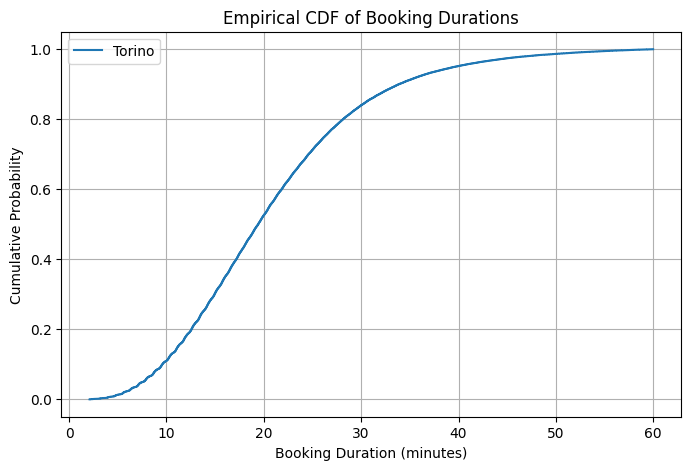

In [5]:
#Task 1: checking if data is already filtered
booking_duration = []
for doc in Bookings_col.find({"city": "Torino"}):
    booking_duration.append(doc["final_time"]- doc["init_time"])
    
booking_durations_np = np.array(booking_duration)/60
sorted_durations = np.sort(booking_durations_np)

cumulative_probabilities = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)

plt.figure(figsize=(8, 5))
plt.plot(sorted_durations, cumulative_probabilities, label="Torino")


plt.xlabel("Booking Duration (minutes)")
plt.ylabel("Cumulative Probability")
plt.title("Empirical CDF of Booking Durations")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
#Task 1: OD matrix of all bookings
od_matrix = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$match": { 
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix[i, j] = 0



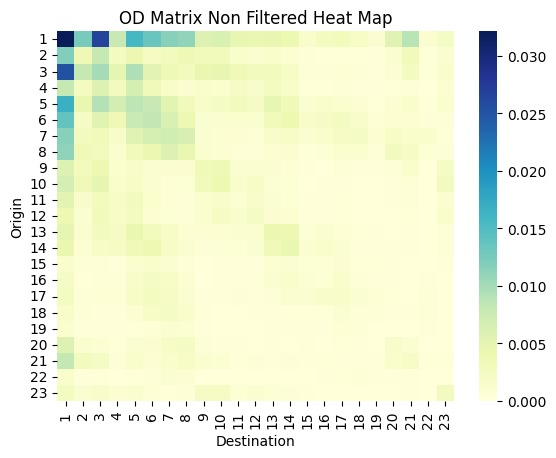

In [7]:
#Task 1: Heat map plot
tot_sum = np.sum(od_matrix)
od_matrix_norm = od_matrix / tot_sum

plt.figure()
sns.heatmap(od_matrix_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Non Filtered Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()


In [8]:
#Task 1a: filtering data by weekdays
od_matrix_weekdays = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    #"hour": { "$hour": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_weekdays[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_weekdays[i, j] = 0

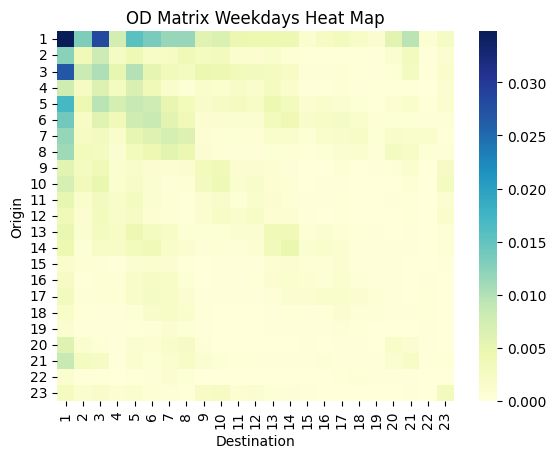

In [9]:
tot_sum = np.sum(od_matrix_weekdays)
od_matrix_weekdays_norm = od_matrix_weekdays / tot_sum

plt.figure()
sns.heatmap(od_matrix_weekdays_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Weekdays Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [10]:
#Task 1a: filtering data by weekends
od_matrix_weekends = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    #"hour": { "$hour": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$in": [1, 7]},
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_weekends[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_weekends[i, j] = 0

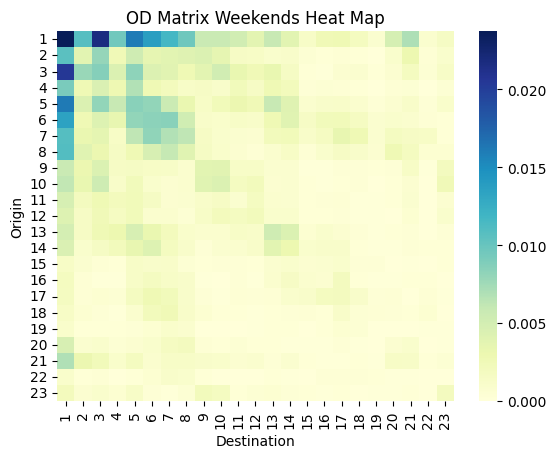

In [11]:
tot_sum = np.sum(od_matrix_weekends)
od_matrix_weekends_norm = od_matrix_weekends / tot_sum

plt.figure()
sns.heatmap(od_matrix_weekends_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Weekends Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [12]:
pipeline = [
    {
        "$group": {
            "_id": None,
            "minDate": { "$min": "$init_date" }, 
            "maxDate": { "$max": "$init_date" }   
        }
    }
]

result = list(Enjoy_Bookings_col.aggregate(pipeline))

print("Start Date:", result[0]['minDate'])
print("End Date:", result[0]['maxDate'])


Start Date: 2017-09-01 00:03:29
End Date: 2017-10-31 23:58:50


In [13]:
#Task 1b: filter for just a week of data (week 36 of 2017) Start: Monday, September 4th, 2017
od_matrix_week36 = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 36 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week36[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week36[i, j] = 0

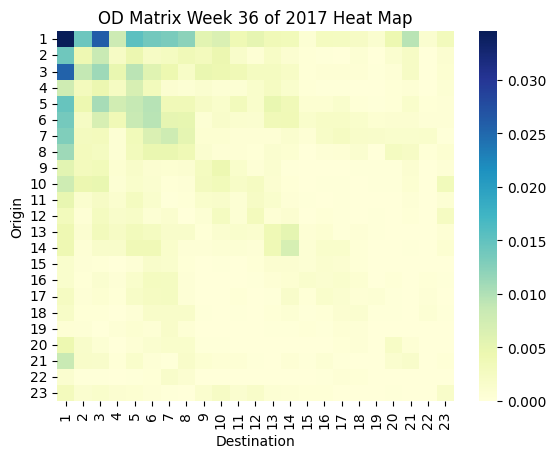

In [14]:
tot_sum = np.sum(od_matrix_week36)
od_matrix_week36_norm = od_matrix_week36 / tot_sum

plt.figure()
sns.heatmap(od_matrix_week36_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 36 of 2017 Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [15]:
#Task 1b: filter for just a week of data (week 39 of 2017) Start: Monday, September 25, 2017
od_matrix_week39 = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 39 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week39[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week39[i, j] = 0

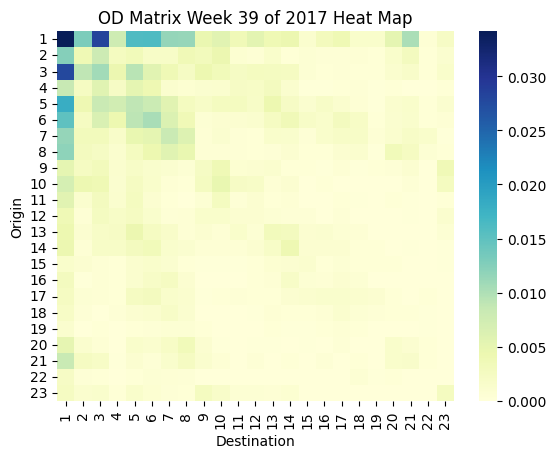

In [16]:
tot_sum = np.sum(od_matrix_week39)
od_matrix_week39_norm = od_matrix_week39 / tot_sum

plt.figure()
sns.heatmap(od_matrix_week39_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 39 of 2017 Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [17]:
#Task 1b: filter for just a week of data (week 39 of 2017) Start: Monday, September 25, 2017
od_matrix_week39_enjoy = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 39 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Enjoy_Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week39_enjoy[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week39_enjoy[i, j] = 0

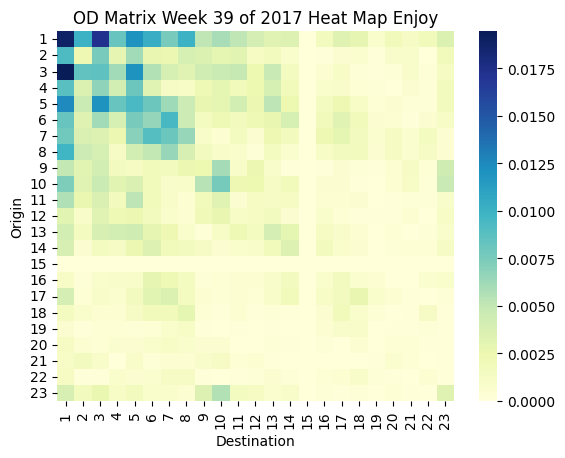

In [18]:
tot_sum = np.sum(od_matrix_week39_enjoy)
od_matrix_week39_enjoy_norm = od_matrix_week39_enjoy / tot_sum

plt.figure()
sns.heatmap(od_matrix_week39_enjoy_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 39 of 2017 Heat Map Enjoy")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [19]:
rand_matrix_A = np.random.rand(23, 23)
rand_matrix_A = rand_matrix_A / np.sum(rand_matrix_A)

rand_matrix_B = np.random.rand(23, 23)
rand_matrix_B = rand_matrix_B / np.sum(rand_matrix_B)

In [20]:
def simple_distance(matrix1, matrix2):
    return np.sum(np.abs(matrix1 - matrix2))

d1_rand = simple_distance(rand_matrix_A, rand_matrix_B)
print(f"Absolute distance between random matrixes: {d1_rand}")
d1_weeks = simple_distance(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Absolute distance between week 36 and 39: {d1_weeks}")
d1_platfrom = simple_distance(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Absolute distance between Car2go and Enjoy: {d1_platfrom}")

Absolute distance between random matrixes: 0.6717181186031648
Absolute distance between week 36 and 39: 0.22451423433648007
Absolute distance between Car2go and Enjoy: 0.40182221926214634


In [21]:
def euclidean_distance(matrix1, matrix2):
    return np.sqrt(np.sum((matrix1 - matrix2)**2))

d2_rand = euclidean_distance(rand_matrix_A, rand_matrix_B)
print(f"Euclidean distance between random matrixes: {d2_rand}")
d2_weeks = euclidean_distance(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Euclidean distance between week 36 and 39: {d2_weeks}")
d2_platfrom = euclidean_distance(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Euclidean distance between Car2go and Enjoy: {d2_platfrom}")

Euclidean distance between random matrixes: 0.03587521336181192
Euclidean distance between week 36 and 39: 0.014469360864313519
Euclidean distance between Car2go and Enjoy: 0.033929065764338504


In [22]:
def max_absolute_difference(A, B):
    absolute_diff = np.abs(A - B)
    return np.max(absolute_diff)

dMax_rand = max_absolute_difference(rand_matrix_A, rand_matrix_B)
print(f"Max absolute difference between random matrixes: {dMax_rand}")
dMax_weeks = max_absolute_difference(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max absolute difference between week 36 and 39: {dMax_weeks}")
dMax_platfrom = max_absolute_difference(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max absolute difference between Car2go and Enjoy: {dMax_platfrom}")

Max absolute difference between random matrixes: 0.003610159928050126
Max absolute difference between week 36 and 39: 0.003416542416515265
Max absolute difference between Car2go and Enjoy: 0.015290397778564238


In [39]:
def compute_dm(A, B):
    M = A - B
    n = M.shape[0]  # Size of the matrix
    x = np.random.rand(n)  # Random vector
    x /= np.linalg.norm(x)  # Normalize it to have ||x|| = 1
    for _ in range(100):
        x = M.T @ (M @ x)  # Multiply by M.T @ M
        x /= np.linalg.norm(x)  # Normalize to ensure ||x|| = 1
    max_norm = np.linalg.norm(M @ x)
    return max_norm

dNorm_rand = compute_dm(rand_matrix_A, rand_matrix_B)
print(f"Max norm of the difference between random matrixes: {dNorm_rand}")
dNorm_weeks = compute_dm(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max norm of the difference between week 36 and 39: {dNorm_weeks}")
dNorm_platfrom = compute_dm(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max norm of the difference between Car2go and Enjoy: {dNorm_platfrom}")

Max norm of the difference between random matrixes: 0.014929976221766566
Max norm of the difference between week 36 and 39: 0.007273287611600088
Max norm of the difference between Car2go and Enjoy: 0.02716255379026128


In [40]:

def compute_dm2(A, B, iterations=100, tol=1e-9):
    # Step 1: Compute the difference matrix M = A - B
    M = A - B
    n = M.shape[0]  # Number of rows/columns (assuming square matrix)
    
    # Step 2: Start with a random vector x
    x = np.random.rand(n)
    x /= np.linalg.norm(x)  # Normalize x to have ||x|| = 1
    
    # Step 3: Perform power iteration
    prev_norm = 0
    for _ in range(iterations):
        # Multiply M by the current vector x
        x = M @ x
        
        # Compute the 2-norm of the resulting vector
        current_norm = np.linalg.norm(x)
        
        # Normalize x for the next iteration
        x /= current_norm
        
        # Check for convergence
        if abs(current_norm - prev_norm) < tol:
            break
        prev_norm = current_norm
    
    return current_norm

dNorm_rand2 = compute_dm2(rand_matrix_A, rand_matrix_B)
print(f"Max norm of the difference between random matrixes: {dNorm_rand2}")
dNorm_weeks2 = compute_dm2(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max norm of the difference between week 36 and 39: {dNorm_weeks2}")
dNorm_platfrom2 = compute_dm2(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max norm of the difference between Car2go and Enjoy: {dNorm_platfrom2}")

Max norm of the difference between random matrixes: 0.007948799951147417
Max norm of the difference between week 36 and 39: 0.005145793550818223
Max norm of the difference between Car2go and Enjoy: 0.026708361522990907
